In [9]:
!pip install radiant_mlhub
!mlhub configure

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
API Key: 549a3aaf6ac01c632b4810633b2752900cbf48a9406d460f5b19460b620e1d26
Overwrite existing API Key (****0e1d26) [y/N]: y
Wrote profile to /root/.mlhub/profiles


In [7]:
import os

os.environ['MLHUB_API_KEY'] = '549a3aaf6ac01c632b4810633b2752900cbf48a9406d460f5b19460b620e1d26'

In [15]:
import json
import re
from glob import glob
import tarfile

import numpy as np
import pandas as pd
from pathlib import Path
from radiant_mlhub import Dataset, Collection, client
from google.colab import drive
import matplotlib.pyplot as plt

In [18]:
# Download the dataset
dataset = Dataset.fetch('nasa_tropical_storm_competition')

# Use this to download the the typical Mac user Downloads folder
download_dir = Path('./').resolve()
# NOTE: Extracting the archives takes a while so this cell may take 5-10 minutes to complete
archive_paths = dataset.download(output_dir=download_dir)
for archive_path in archive_paths:
    print(f'Extracting {archive_path}...')
    with tarfile.open(archive_path) as tfile:
        tfile.extractall(path=download_dir)
print('Done')

Extracting /content/nasa_tropical_storm_competition_train_source.tar.gz...
Extracting /content/nasa_tropical_storm_competition_test_source.tar.gz...
Extracting /content/nasa_tropical_storm_competition_train_labels.tar.gz...
Extracting /content/nasa_tropical_storm_competition_test_labels.tar.gz...
Done


In [19]:
train_data = []

train_source = 'nasa_tropical_storm_competition_train_source'
train_labels = 'nasa_tropical_storm_competition_train_labels'
# Use this to download to a data folder the current working directory
#download_dir = Path('./')
# # Use this to download the the typical Mac user Downloads folder
# download_dir = Path('~/Downloads').expanduser().resolve()
jpg_names = glob(str(download_dir / train_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)
    
    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]
    labels_path = str(jpg_path.parent / 'labels.json').replace(train_source, train_labels)


    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)
        
    # Load the labels data
    # with open(labels_path) as src:
    #     labels_data = json.load(src)

    train_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean'])
        # int(labels_data['wind_speed'])
    ])

In [22]:
train_df = pd.DataFrame(
    np.array(train_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean']
).sort_values(by=['Image ID']).reset_index(drop=True)

train_df.head()

,Image ID,Storm ID,Relative Time,Ocean
0,abs_000,abs,0,2
1,abs_001,abs,1800,2
2,abs_002,abs,5400,2
3,abs_003,abs,17999,2
4,abs_004,abs,19799,2


In [23]:
test_data = []

test_source = 'nasa_tropical_storm_competition_test_source'

jpg_names = glob(str(download_dir / test_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)

    # Get the IDs and file paths
    features_path = jpg_path.parent / 'features.json'
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[-2:])
    storm_id = image_id.split('_')[0]

    # Load the features data
    with open(features_path) as src:
        features_data = json.load(src)

    test_data.append([
        image_id, 
        storm_id, 
        int(features_data['relative_time']), 
        int(features_data['ocean']), 
    ])

test_df = pd.DataFrame(
    np.array(test_data),
    columns=['Image ID', 'Storm ID', 'Relative Time', 'Ocean']
).sort_values(by=['Image ID']).reset_index(drop=True)

test_df.head()

,Image ID,Storm ID,Relative Time,Ocean
0,acd_123,acd,304198,1
1,acd_124,acd,305998,1
2,acd_125,acd,307798,1
3,acd_126,acd,309598,1
4,acd_127,acd,313198,1


We combine the train and test set as a whole dataset which will be used for training later.

In [24]:
data = train_df.append(test_df)

# **Data Exploratory**

We have 114634 images in the dataset.

In [34]:
print('Training data:',data.shape)

Training data: (114634, 4)


Let's take a look at how many storms are in the training and testing data, and how many images we have per storm.

In [36]:
print('Number of storms in training data:',data["Storm ID"].nunique())

Number of storms in training data: 638


In [37]:
storm_counts = data.groupby("Storm ID").size()
storm_counts.describe()

count    638.000000
mean     179.677116
std      124.488779
min        4.000000
25%       84.000000
50%      157.500000
75%      248.000000
max      648.000000
dtype: float64

Text(0.5, 1.0, 'Number of Images per Storm')

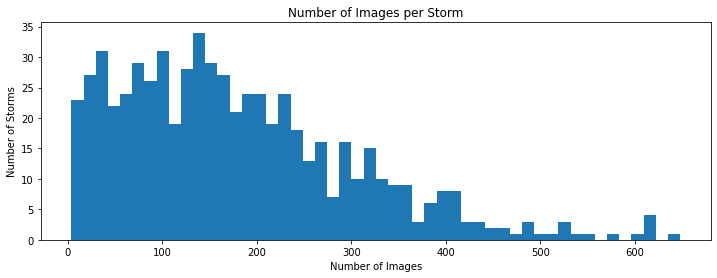

In [38]:
plt.figure(figsize=(12, 4))
plt.hist(storm_counts, bins=50)
plt.xlabel("Number of Images")
plt.ylabel("Number of Storms")
plt.title("Number of Images per Storm")

The training data contain images from 638 storms. We have anywhere from 4 to 648 images per unique storm, with many storms containing less than 200 images.

Now, let's see the distributions of time difference of the capture images for each storm.

In [94]:
data = data.sort_values(by=['Storm ID','Image ID'], ascending = [True, True])

In [168]:
from collections import defaultdict
# Compute the time difference for each storm 
time_diff = defaultdict(list)
storm_id = data['Storm ID'].unique()
for storm in storm_id:
    for index,row in data[data['Storm ID']==storm][1:].iterrows():
      stormid = storm+str(index)
      time_diff[stormid]=(int(data.iloc[index]['Relative Time']) - int(data.iloc[index-1]['Relative Time']))

In [176]:
timeDiff = pd.DataFrame.from_dict(time_diff,orient = 'index').reset_index()
timeDiff['index'] = timeDiff['index'].apply(lambda x: x[:3])
timeDiff.columns = ['Storm ID','Time Diff']

In [178]:
timeDiff.groupby('Storm ID').describe()

Time Diff                                                             \
             count         mean          std     min     25%     50%      75%   
Storm ID                                                                        
abs           56.0  2925.000000  2800.195675  1796.0  1800.0  1800.0  3599.25   
acd          223.0  2502.237668  1704.373828  1798.0  1800.0  1800.0  1801.00   
aek          107.0  3600.009346     0.167969  3599.0  3600.0  3600.0  3600.00   
afs          220.0  2626.354545  3030.189486  1798.0  1800.0  1801.0  3600.00   
agb          132.0  2263.636364  1550.831997  1799.0  1800.0  1800.0  1800.00   
...            ...          ...          ...     ...     ...     ...      ...   
zvx          101.0  3600.029703     0.221605  3599.0  3600.0  3600.0  3600.00   
zwh           77.0  2197.376623   905.732766  1797.0  1800.0  1800.0  1802.00   
zyp          126.0  2200.007937   878.606383  1798.0  1800.0  1800.0  1800.00   
zza          178.0  2164.056180   749.804168  1799.0  1800.0  1800.0  1801.00   
zzp          225.0  2575.991111  1739.274297  1798.0  1800.0  1800.0  3598.00   

                   
              max  
Storm ID           
abs       12600.0  
acd       10801.0  
aek        3601.0  
afs       45001.0  
agb       18000.0  
...           ...  
zvx        3601.0  
zwh        7199.0  
zyp        7199.0  
zza        5399.0  
zzp       10800.0  

[638 rows x 8 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64f6d03e10>]],
      dtype=object)

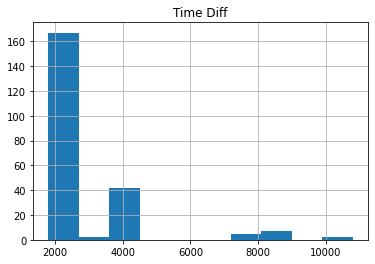

In [198]:
timeDiff[timeDiff['Storm ID']=='zzp'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64fd8f26d0>]],
      dtype=object)

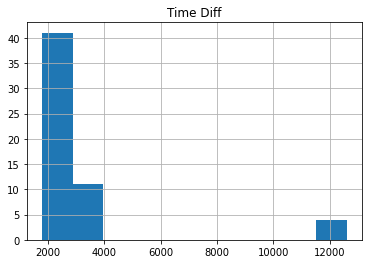

In [186]:
timeDiff[timeDiff['Storm ID']=='abs'].hist()

We can see that the time difference of the images are not distributed evenly for some storms which this case causes the inconsistencies of the timestamp and there are some missing images of the storms. In order to ensure the even distribution of our training set, we need to handle the inconsistency by generating and inserting some images accordingly.